# Task 1 – Exploratory Data Analysis (EDA)

This notebook performs initial EDA on the insurance claims dataset using the
modular code in the `src` package. It focuses on:

- Understanding the basic structure of the data.
- Computing overall and grouped loss ratios.
- Preparing for more detailed visual analysis in later notebooks.


In [1]:
# Set up imports and configuration
import sys
from pathlib import Path

# Determine project root by searching upwards for the `src` directory
project_root = Path.cwd().resolve()
if not (project_root / "src").exists():
    # If running from notebooks/ or another subdir, move one level up
    candidate = project_root.parent
    if (candidate / "src").exists():
        project_root = candidate

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data_loader import DataLoader
from src.eda_summary import compute_loss_ratio_overall, compute_loss_ratio_by_group

loader = DataLoader.from_config()
df = loader.load_machine_learning_rating()
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


### Interpretation – first look at the data

- We have just over **1 million rows** and **52 columns**, so this is a large portfolio.
- Many columns are **categorical** (object type) describing client, vehicle, and cover.
- Key numeric fields include `TotalPremium`, `TotalClaims`, `SumInsured`, and engine-related specs.
- Some fields have **heavy missingness** (e.g. `NumberOfVehiclesInFleet`, `CrossBorder`, `CustomValueEstimate`), which we must treat carefully in later analysis.

In [2]:
# Basic info and summary statistics
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

### Interpretation – overall loss ratio

- The overall **loss ratio** (TotalClaims / TotalPremium) is shown above.
- A value **around 1** implies claims paid are similar to premiums collected.
- Values **> 1** indicate the portfolio is, on average, **unprofitable** (claims exceed premiums).
- This high-level metric motivates drilling down by province, vehicle type, and gender.

In [3]:
# Overall loss ratio for the portfolio
overall_lr = compute_loss_ratio_overall(df)
overall_lr


1.0477452570332206

### Interpretation – loss ratio by Province

- Provinces are sorted from **highest** to **lowest** loss ratio.
- Provinces with a loss ratio **well above 1** (e.g. Gauteng) are **riskier** and may require higher premiums or stricter underwriting.
- Provinces with ratios **below or near 1** look relatively **healthier** from a profitability perspective.
- These differences will later feed into **hypothesis tests** and **pricing decisions**.

In [4]:
# Loss ratio by Province
lr_by_province = compute_loss_ratio_by_group(df, ["Province"])
lr_by_province.sort_values('loss_ratio', ascending=False).head()


,Province,total_premium,total_claims,loss_ratio
2,Gauteng,2.405377e+07,2.939415e+07,1.222018
3,KwaZulu-Natal,1.320908e+07,1.430138e+07,1.082693
8,Western Cape,9.806559e+06,1.038977e+07,1.059472
6,North West,7.490508e+06,5.920250e+06,0.790367
5,Mpumalanga,2.836292e+06,2.044675e+06,0.720897


### Interpretation – missing values

- The table shows columns ordered by **percentage of missing values**.
- Columns with ~100% missing (e.g. `NumberOfVehiclesInFleet`) carry **almost no usable information** and may be dropped.
- Heavily missing business fields (e.g. `CrossBorder`, `CustomValueEstimate`) may require **careful imputation** or be used only in limited analyses.
- Low levels of missingness in key variables (e.g. `TotalPremium`, `TotalClaims`) are reassuring for modeling.

In [5]:
# Missing value analysis
from src.eda_missing import compute_missing_values

missing_stats = compute_missing_values(df)
missing_stats.head(20)

,column,missing_count,missing_pct
0,NumberOfVehiclesInFleet,1000098,100.000000
1,CrossBorder,999400,99.930207
2,CustomValueEstimate,779642,77.956560
3,Rebuilt,641901,64.183810
4,Converted,641901,64.183810
5,WrittenOff,641901,64.183810
6,NewVehicle,153295,15.327998
7,Bank,145961,14.594670
8,AccountType,40232,4.022806
9,Gender,9536,0.953507


### Interpretation – distributions of TotalPremium and TotalClaims

- The histograms show **highly skewed** distributions, with many small premiums/claims and a few very large ones.
- The **log-scale y-axis** makes the rare but large values visible.
- This skewness suggests we may need **robust metrics** (medians, percentiles) and possibly **log-transformations** in some models.

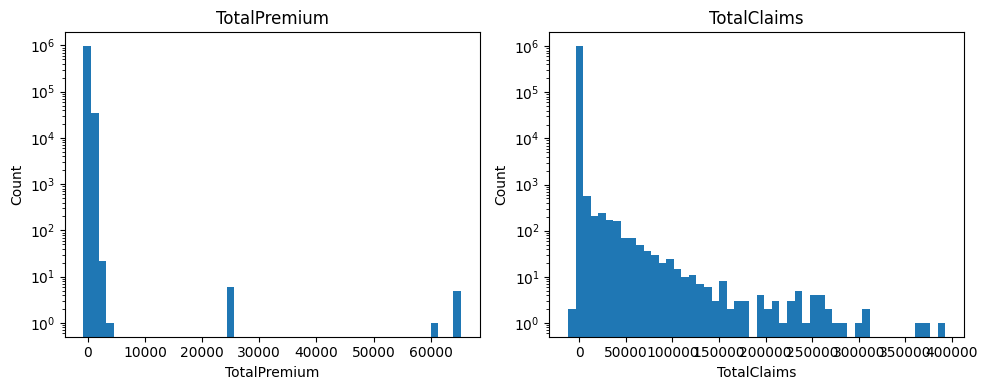

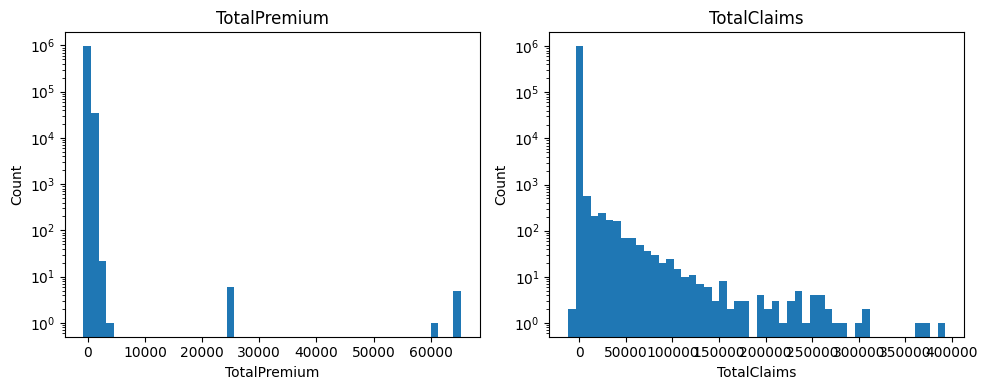

In [6]:
# Basic distributions for key numeric variables
from src.eda_plots import plot_histograms

fig = plot_histograms(df, ["TotalPremium", "TotalClaims"], bins=50, log_scale=True)
fig

### Interpretation – loss ratio by VehicleType

- Vehicle types (e.g. passenger, light commercial, heavy commercial) differ substantially in loss ratio.
- **Heavy/medium commercial** vehicles tend to have **higher loss ratios**, suggesting greater risk.
- Some categories show loss ratios well above 1, signaling potential underpricing or higher inherent risk.

In [7]:
# Outlier analysis using high quantiles and IQR bounds
from src.eda_outliers import compute_high_quantiles, compute_iqr_bounds

# High quantiles for TotalPremium and TotalClaims
outlier_quantiles = compute_high_quantiles(df, ["TotalPremium", "TotalClaims"])
outlier_quantiles

,column,q75,q90,q95,q99
0,TotalPremium,21.929825,210.594298,404.877982,778.698158
1,TotalClaims,0.000000,0.000000,0.000000,0.000000


### Interpretation – loss ratio by Gender

- This table compares average loss ratio between **male**, **female**, and possibly **unknown** gender categories.
- Significant differences here would justify separate **pricing or segmentation** by gender (subject to regulatory and ethical constraints).
- If loss ratios are similar, gender may be **less important** as a standalone rating factor.

In [8]:
# Time trend analysis: monthly loss ratio over TransactionMonth
from src.eda_trends import prepare_monthly_loss_ratio

monthly_lr = prepare_monthly_loss_ratio(df)
monthly_lr.head()

,month,total_premium,total_claims,loss_ratio
0,2013-10-01,371.063512,0.000000,0.000000
1,2013-11-01,21307.467009,50585.078947,2.374054
2,2013-12-01,42484.748888,9283.385965,0.218511
3,2014-01-01,54085.196865,12436.859649,0.229949
4,2014-02-01,60788.436470,62989.307018,1.036205


### Interpretation – loss ratio by Province (bar chart)

- The bar chart makes provincial differences **visually obvious**.
- Provinces with much higher bars (loss ratios) are **risk concentration areas**.
- These insights will be useful when we test formal hypotheses like: *"There are no risk differences across provinces"* in later tasks.

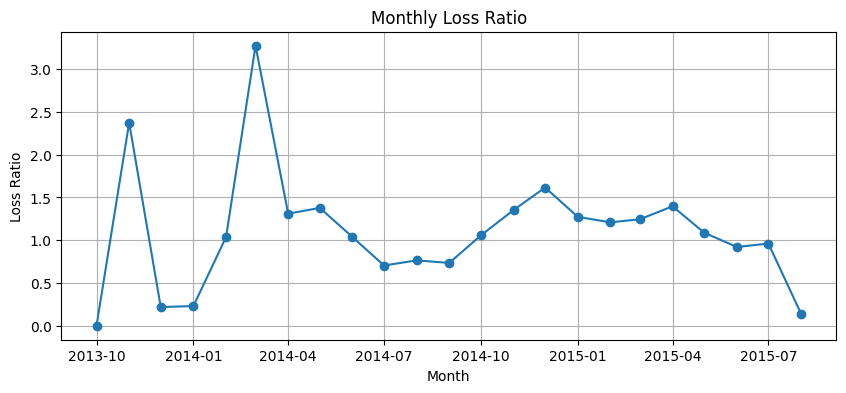

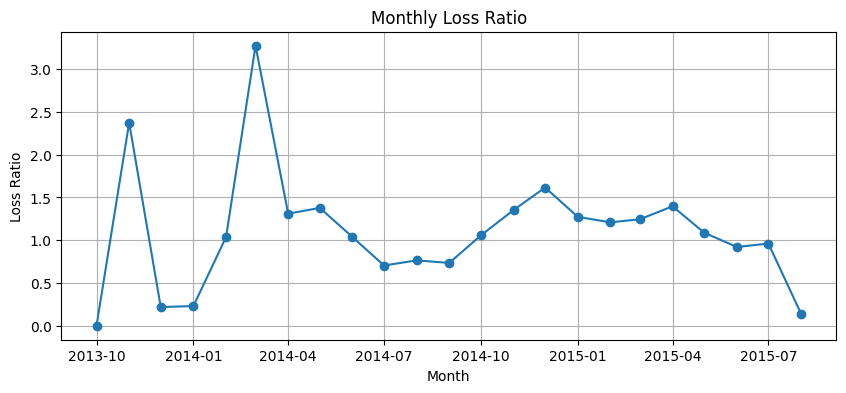

In [9]:
# Plot monthly loss ratio trend
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(monthly_lr["month"], monthly_lr["loss_ratio"], marker="o")
ax.set_title("Monthly Loss Ratio")
ax.set_xlabel("Month")
ax.set_ylabel("Loss Ratio")
ax.grid(True)
fig

### Interpretation – monthly loss ratio trend

- The monthly line chart shows how **portfolio risk evolves over time**.
- Upward spikes may correspond to **bad months** (e.g. more or larger claims) and warrant investigation.
- A stable or gently varying loss ratio is preferable; strong upward trends could indicate **deteriorating risk** or pricing that is not keeping up.

In [14]:
# Loss ratio by Gender
lr_by_gender = compute_loss_ratio_by_group(df, ["Gender"])
lr_by_gender.sort_values("loss_ratio", ascending=False).head()

,Gender,total_premium,total_claims,loss_ratio
2,Not specified,5.920275e+07,6.271410e+07,1.059311
1,Male,1.580143e+06,1.396704e+06,0.883910
0,Female,3.044806e+05,2.502461e+05,0.821879
3,NaN,8.241871e+05,5.064931e+05,0.614537


## Task 1 – EDA summary observations

From the analyses above we can summarise:

- **Portfolio level**
  - Overall loss ratio is around 1, indicating that, on average, claims are of similar magnitude to premiums.
- **Geography (Province)**
  - Some provinces (e.g. Gauteng) exhibit **notably higher loss ratios**, suggesting regional risk differences.
- **VehicleType**
  - Heavy and medium commercial vehicles tend to show **higher loss ratios** than passenger vehicles.
- **Gender**
  - Loss ratios by gender can be compared to assess whether there is a meaningful risk difference between men and women.
- **Missing data**
  - Several fields have **very high missingness**, limiting their usefulness and requiring careful treatment.
- **Distributions & outliers**
  - `TotalPremium` and `TotalClaims` are **heavily skewed**, with a long tail of large values and clear potential outliers.
- **Time trends**
  - The monthly loss ratio series indicates how risk changes over time and highlights any unusually bad or good months.

These findings give us a solid statistical and business understanding of the dataset and prepare us for the next tasks: **formal hypothesis testing (Task 3)** and **predictive modeling (Task 4)**.

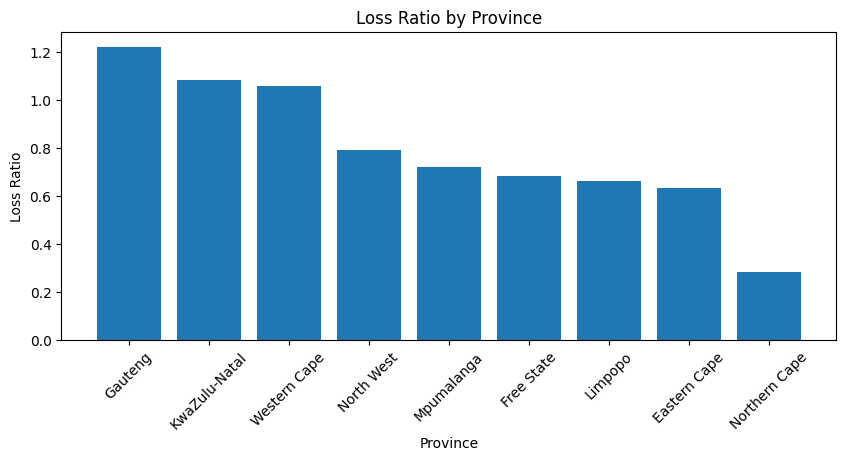

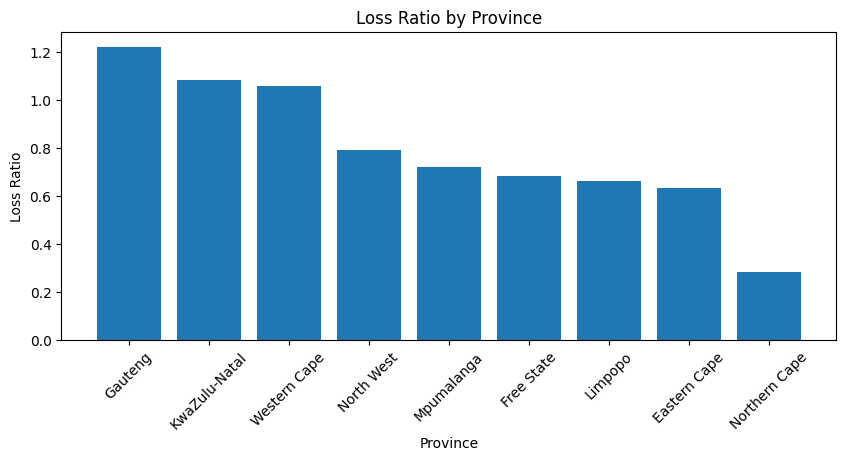

In [15]:
# Visualise loss ratio by Province as a bar plot
import matplotlib.pyplot as plt

lr_by_province_sorted = lr_by_province.sort_values("loss_ratio", ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(lr_by_province_sorted["Province"], lr_by_province_sorted["loss_ratio"])
ax.set_title("Loss Ratio by Province")
ax.set_xlabel("Province")
ax.set_ylabel("Loss Ratio")
ax.tick_params(axis="x", rotation=45)
fig

In [12]:
# Outlier analysis using high quantiles and IQR bounds
from src.eda_outliers import compute_high_quantiles, compute_iqr_bounds

# High quantiles for TotalPremium and TotalClaims
outlier_quantiles = compute_high_quantiles(df, ["TotalPremium", "TotalClaims"])
outlier_quantiles

,column,q75,q90,q95,q99
0,TotalPremium,21.929825,210.594298,404.877982,778.698158
1,TotalClaims,0.000000,0.000000,0.000000,0.000000


In [13]:
# Loss ratio by VehicleType
lr_by_vehicle_type = compute_loss_ratio_by_group(df, ["VehicleType"])
lr_by_vehicle_type.sort_values('loss_ratio', ascending=False).head()


,VehicleType,total_premium,total_claims,loss_ratio
1,Heavy Commercial,4.609479e+05,7.504746e+05,1.628112
3,Medium Commercial,3.922746e+06,4.119867e+06,1.050251
4,Passenger Vehicle,5.664202e+07,5.937207e+07,1.048198
5,NaN,5.671104e+05,5.566860e+05,0.981618
2,Light Commercial,2.604975e+05,6.045250e+04,0.232066
